# Project 2: Topic Classification
## Author: Suhas Gupta
### MIDS W207 Section 6
#### Submission Date : 03/09/2019

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [371]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[int(num_test/2):], newsgroups_test.target[int(num_test/2):]
dev_data, dev_labels = newsgroups_test.data[:int(num_test/2)], newsgroups_test.target[:int(num_test/2)]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('test label shape:', test_labels.shape)
print('dev label shape:', dev_labels.shape)
print('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [3]:
def P1(num_examples=5):

### STUDENT START ###
    # Sort the categories to match the original data directory structure of the newgroups 20 data set.
    categories.sort()
    for text, label in zip (train_data[:num_examples], train_labels[:num_examples]):
        print("Label:\t %s \n" % (categories[label]))
        print("Text:\n %s \n" % (text))
### STUDENT END ###

P1()

Label:	 comp.graphics 

Text:
 Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych 

Label:	 talk.religion.misc 

Text:
 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for cen

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [4]:
def P2():

### STUDENT START ###
    vect = CountVectorizer()
    vect_train = vect.fit_transform(train_data)
    train_features =  vect.get_feature_names()

    #a.1: Size of the vocabulary
    vocab_size_train_unigram = vect_train.shape[1]
    
    #a.2: Average number of non zero feautres per example
    nnz_train_unigram = vect_train.nnz
    vect_training_examples = vect_train.shape[0]
    mean_nnz_train_unigram = nnz_train_unigram/vect_training_examples
    
    #a.3: Fraction of non zero entries in the matrix
    entries_matrix_train_unigram = vect_train.shape[0] * vect_train.shape[1]
    frac_nnz_train_unigram = nnz_train_unigram/entries_matrix_train_unigram
    
    print("Answers to Part a:\n")
    print("--------------------")
    print("Unigram Vocabulary size: {vocab}\n".format(vocab=vocab_size_train_unigram))
    print("Mean number of non-zero features per example: {mean_nnz}\n".format(mean_nnz=round(mean_nnz_train_unigram,2)))
    print("Fraction of non-zero entries in matrix: {fnnz_matrix}\n".format(fnnz_matrix=round(frac_nnz_train_unigram,4)))
    
    #b: 0th and last feature strings
    
    feature_names_unigram = vect.get_feature_names()
    print("Answers to Part b:\n")
    print("--------------------")
    print("First feature name (unigram): {first}\n".format(first=feature_names_unigram[0]))
    print("Last feature name (unigram): {last}\n".format(last=feature_names_unigram[-1]))
    
    #c: Specify own vocabulary and confirm training vectors are appropriately shaped
    custom_vocab =  ["atheism", "graphics", "space", "religion"]
    vect_custom_vocab = CountVectorizer(vocabulary= custom_vocab)      
    vect_custom_vocab_train = vect_custom_vocab.fit_transform(train_data)
    
    print("Answers to Part c:\n")
    print("--------------------")
    ## Assert shape of training vectors
    assert vect_custom_vocab_train.shape[0] == len(train_data), "Training vector row has wrong shape"
    assert vect_custom_vocab_train.shape[1] == len(custom_vocab), "Training vector column has wrong shape"
    # Compute new mean of non zero features
    nnz_train_unigram_custom = vect_custom_vocab_train.nnz
    mean_nnz_train_unigram_custom = nnz_train_unigram_custom/vect_custom_vocab_train.shape[0]
    print("Mean number of non-zero features per example: {mean_nnz}\n".format(mean_nnz=round(mean_nnz_train_unigram_custom,4)))

    #d: Bigram and trigram features
    
    ## Since news articles are in english, use the char_wb analyzer to only construct feautres from chacracters inside the word boundaries (separated by white spaces)
    bigram_trigram_vect = CountVectorizer(analyzer = "char", ngram_range=(2, 3))
    bigram_trigram_vect_train = bigram_trigram_vect.fit_transform(train_data)
    bigram_trigram_vect_train_size = bigram_trigram_vect_train.shape[1]
    print("Answer to Part d:\n")
    print("--------------------")
    print("Vocabulary Size with bigram & trigram characters: {sz}\n".format(sz=bigram_trigram_vect_train_size))
    mean_nnz_bigram_trigram = bigram_trigram_vect_train.nnz/bigram_trigram_vect_train.shape[0]
    print("Mean number of non-zero features per example(bigram, trigram): {mean_nnz}\n".format(mean_nnz=round(mean_nnz_bigram_trigram,4)))
    
    #e: Prune vocabulary
    vect_min10 = CountVectorizer(min_df=10)
    vect_min10_train = vect_min10.fit_transform(train_data)
    vocab_min10_size = vect_min10_train.shape[1]
    mean_nnz_train_min10 = vect_min10_train.nnz/vect_min10_train.shape[0]
    print("Answer to Part e:\n")
    print("--------------------")
    print("Vocabulary size with min_df=10: {sz}\n".format(sz=vocab_min10_size))
    print("Mean number of non-zero features per example(min_df=10): {mean_nnz}\n".format(mean_nnz=round(mean_nnz_train_min10,4)))
    
    #f: Words in dev data missing from training vocab
    vect_dev =  CountVectorizer()
    vect_dev_fit = vect_dev.fit_transform(dev_data)
    vect_dev_fit_size = vect_dev_fit.shape[1]
    dev_features = vect_dev.get_feature_names()
    words_in_dev_not_in_train = set(dev_features) - set(train_features)
    frac_words_in_dev_not_in_train = len(words_in_dev_not_in_train)/vect_dev_fit_size
    print("Answer to Part f:\n")
    print("--------------------")
    print("Number of words in dev data set missing from training data set: {sz}\n".format(sz=len(words_in_dev_not_in_train)))
    print("Fraction of dev data set words missing from training data set: {fc}\n".format(fc=round(frac_words_in_dev_not_in_train,4)))
    

### STUDENT END ###

P2()


Answers to Part a:

--------------------
Unigram Vocabulary size: 26879

Mean number of non-zero features per example: 96.71

Fraction of non-zero entries in matrix: 0.0036

Answers to Part b:

--------------------
First feature name (unigram): 00

Last feature name (unigram): zyxel

Answers to Part c:

--------------------
Mean number of non-zero features per example: 0.2684

Answer to Part d:

--------------------
Vocabulary Size with bigram & trigram characters: 35478

Mean number of non-zero features per example(bigram, trigram): 684.1917

Answer to Part e:

--------------------
Vocabulary size with min_df=10: 3064

Mean number of non-zero features per example(min_df=10): 72.676

Answer to Part f:

--------------------
Number of words in dev data set missing from training data set: 4027

Fraction of dev data set words missing from training data set: 0.2479



(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

F1-score of K Nearest Neighbors with k=1: 0.3805
Best F1-score for KNN : 0.4048 with 1-N_neighbors
Best F1-score for MNB : 0.8275789300795278 with alpha = 0.052631579894736845


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best F1-score for Logistic Regression : 0.7719909586460159 with C = 0.21052631657894738


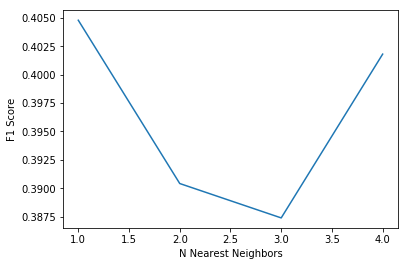

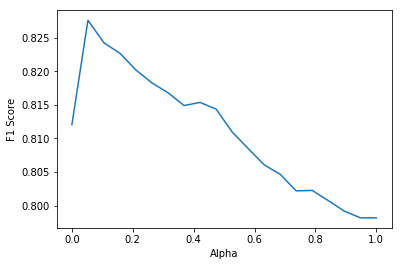

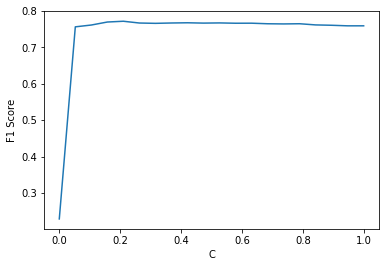

In [5]:
def P3():

### STUDENT START ###
    # Define a pipeline and optimizer function
    def find_optimal(classifier,params):
        model = Pipeline([('vect', CountVectorizer()),('classifier', classifier)])
        model = model.fit(train_data, train_labels)
        model_predictions = model.predict(dev_data)
        optimize_model = GridSearchCV(model, params,scoring='f1_weighted',cv=3)
        optimize_model.fit(train_data,train_labels)
        return optimize_model
    # Setup a pipeline for KNN classifier with k=1
    KNN1 = Pipeline([('vect', CountVectorizer()),('clf', KNeighborsClassifier(n_neighbors=1))])
    # fit and predict KNN1 model and get F1 score
    KNN1.fit(train_data, train_labels)
    KNN1_predictions = KNN1.predict(dev_data)
    f1_score = round(metrics.f1_score(dev_labels,KNN1_predictions,average='weighted'),4)
    print("F1-score of K Nearest Neighbors with k=1: {f1score}".format(f1score=f1_score))

    # Find optimum hyper parameters for KNN, Naiver Bayes & Logisitic Regression classifiers
    
    KNN = find_optimal(KNeighborsClassifier(),params={"classifier__n_neighbors":np.arange(1,5)})
    KNN_mean_scores = KNN.cv_results_['mean_test_score']
    KNN_nn_params = KNN.cv_results_['param_classifier__n_neighbors']
    print("Best F1-score for KNN : {f1} with {nn}-N_neighbors".format(f1=round(KNN.best_score_,4),nn=KNN.best_params_['classifier__n_neighbors']))

    MNB = find_optimal(MultinomialNB(),params={"classifier__alpha":np.linspace(1e-9,1,20)})
    MNB_mean_scores = MNB.cv_results_['mean_test_score']
    MNB_alpha_params = MNB.cv_results_['param_classifier__alpha']
    print("Best F1-score for MNB : {f1} with alpha = {alpha}".format(f1=MNB.best_score_,alpha=MNB.best_params_['classifier__alpha']))

    LR  = find_optimal(LogisticRegression(solver="liblinear",multi_class="auto"),params={"classifier__C":np.linspace(1e-9,1,20)})     
    LR_mean_scores = LR.cv_results_['mean_test_score']
    LR_C_params = LR.cv_results_['param_classifier__C']
    print("Best F1-score for Logistic Regression : {f1} with C = {C}".format(f1=LR.best_score_,C=LR.best_params_['classifier__C']))
    
    # Plot the grid search results
    plt.plot(KNN_nn_params,KNN_mean_scores)
    plt.xlabel("N Nearest Neighbors")
    plt.ylabel("F1 Score")
    plt.show()

    plt.plot(MNB_alpha_params,MNB_mean_scores)
    plt.xlabel("Alpha")
    plt.ylabel("F1 Score")
    
    plt.show()
    plt.plot(LR_C_params,LR_mean_scores)
    plt.xlabel("C")
    plt.ylabel("F1 Score")
    plt.show()

### STUDENT END ###

P3()

ANSWER:

**3a. In the K-Nearest Neighbors algorithm we compare the each test example with the training examples and predict the test class according to the most similar training example labels. However, for a sparse feature space as in the given dataset, the algorithm has difficulty in accurately differentiating between different training examples during the predinction phase.**

**3b. Logistic regression is under performing compared to Naive Bayes. This maybe due to the fact that we have a large number of features but relatively lower number of training examples (curse of dimensionality).**

**3c:**

In [6]:
C_list = np.linspace(1e-9,2,10)
#coef_squared_sums = np.zeros((len(C_list),4),dtype=float)
coef_squared_sums = list()
#with warnings.catch_warnings():
    #warnings.simplefilter("ignore")
logistic_model = CountVectorizer()
for index, value in enumerate(C_list):
    LR2 = Pipeline([('vect', CountVectorizer()),('classifier', 
                    LogisticRegression(C=value,solver='liblinear',multi_class='auto'))])
    LR2.fit(train_data, train_labels)
    LR2_predictions = LR2.predict(dev_data)
    sum_val = [(round(sum(LR2.named_steps['classifier'].coef_[cat]**2),2)) for cat in range(4)]
    print("C Value : {c_val} | Sum of squared coefficients:{sum}".format(c_val=round(value,2),sum=sum_val))


C Value : 0.0 | Sum of squared coefficients:[0.0, 0.0, 0.0, 0.0]
C Value : 0.22 | Sum of squared coefficients:[54.3, 46.34, 53.69, 46.64]
C Value : 0.44 | Sum of squared coefficients:[93.96, 76.61, 91.02, 81.4]
C Value : 0.67 | Sum of squared coefficients:[126.41, 100.88, 121.0, 109.93]
C Value : 0.89 | Sum of squared coefficients:[154.31, 121.49, 146.43, 134.54]
C Value : 1.11 | Sum of squared coefficients:[178.99, 139.78, 168.91, 156.37]
C Value : 1.33 | Sum of squared coefficients:[201.1, 156.19, 188.93, 176.11]
C Value : 1.56 | Sum of squared coefficients:[221.39, 171.24, 207.33, 194.21]
C Value : 1.78 | Sum of squared coefficients:[240.13, 185.07, 224.21, 210.9]
C Value : 2.0 | Sum of squared coefficients:[257.44, 197.83, 239.95, 226.52]


**The value of C controls the regularization penalty. When the penalty is small, the weighted coefficients drift away from zero at a larger rate as C increases compared to the rate when regularization penalty is large.**

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [379]:
def P4():

### STUDENT START ###
    ## Logisitc regression options
    sol = 'liblinear'
    multi='auto'
    tolerance = 0.01

#------- unigram features------#

    vectorizer = CountVectorizer()
    train_data_features = vectorizer.fit_transform(train_data)
    LR = LogisticRegression(solver=sol,multi_class=multi,tol=tolerance)
    LR.fit(train_data_features, train_labels)
    
    # Get the weights of all the features
    weights = LR.coef_
    
    # Find the 5 features with largest coefficients for each label
    indeces = map(lambda label:abs(weights[label]).argsort()[-5:], range(4))
    
    #flatten the map object to get a list of 20 items
    index_list = [i for j in indeces for i in j]  # iterate over map iterator and nest with each row of map iterator
    
    # get the feature names for the max weight indeces
    feature_names = [vectorizer.get_feature_names()[k] for k in index_list]

    # get the values of the weights for the max weight indeces
    max_weights = [np.round(weights[label][index_list],4) for label in range(4)]
    
    # Print table for unigram weigths
    print("#--------Unigram Weights--------#\n")
    print_format = '|| {0:10} ||{1:15}|{2:15}|{3:15}|{4:20}|'
    print(print_format.format('', categories[0],categories[1],categories[2],categories[3]))
    print_format = '|| {0:10} ||{1:15}|{2:15}|{3:15}|{4:20}|'
    for row in range(len(feature_names)):
        print(print_format.format(feature_names[row], max_weights[0][row], max_weights[1][row], 
                              max_weights[2][row], max_weights[3][row]))
        
        
#------ Bigram features------#  
    ## Repeat everything above with bigram features and fit new logistic regression model
    vectorizer_bigram = CountVectorizer(ngram_range=(2,2)) 
    train_data_features_bigram = vectorizer_bigram.fit_transform(train_data)
    LR_bigram = LogisticRegression(solver=sol,multi_class=multi,tol=tolerance)
    LR_bigram.fit(train_data_features_bigram, train_labels)
    weights_bigram = LR_bigram.coef_
    indeces = map(lambda label:abs(weights_bigram[label]).argsort()[-5:], range(4))
    index_list = [i for j in indeces for i in j]  # iterate over map iterator and nest with each row of map iterator
    feature_names = [vectorizer_bigram.get_feature_names()[k] for k in index_list]
    max_weights = [np.round(weights_bigram[label][index_list],4) for label in range(4)]
    # Print table for unigram weigths
    print("\n\n#--------Bigram Weights--------#\n")
    print_format = '|| {0:20} ||{1:15}|{2:15}|{3:15}|{4:20}|'
    print(print_format.format('', categories[0],categories[1],categories[2],categories[3]))
    print_format = '|| {0:20} ||{1:15}|{2:15}|{3:15}|{4:20}|'
    for row in range(len(feature_names)):
        print(print_format.format(feature_names[row], max_weights[0][row], max_weights[1][row], 
                              max_weights[2][row], max_weights[3][row]))

### STUDENT END ###

P4()

#--------Unigram Weights--------#

||            ||alt.atheism    |comp.graphics  |sci.space      |talk.religion.misc  |
|| atheists   ||           0.98|         0.0049|        -0.1795|             -0.7671|
|| religion   ||         0.9805|        -0.5469|         -0.775|             -0.0715|
|| bobby      ||         1.0188|        -0.2487|        -0.3513|             -0.4779|
|| deletion   ||         1.0473|        -0.2231|        -0.2641|             -0.2634|
|| space      ||        -1.2777|         -1.251|         2.0858|             -1.1548|
|| 3d         ||        -0.3665|          1.062|        -0.6833|             -0.3859|
|| file       ||        -0.3414|         1.1031|        -0.7774|              -0.628|
|| image      ||        -0.5679|         1.1427|        -0.6847|             -0.3163|
|| space      ||        -1.2777|         -1.251|         2.0858|             -1.1548|
|| graphics   ||        -0.7801|         1.8494|         -1.332|             -0.7788|
|| god        ||   

Surprising feature:
**The bigram feature 'cheers kent' seems to have positive and similar value of weights for two categories that is a different characteristic from all other features**.

Let's examine some details about this feature in our data set:


In [380]:
# Examing the 'cheers kent' bigram feature

vectorizer_bigram = CountVectorizer(ngram_range=(2,2)) 
train_data_features_bigram = vectorizer_bigram.fit_transform(train_data)
# Find the index of the feature 'cheers kent' from the transformed feature matrix 
feature_index = vectorizer_bigram.get_feature_names().index("cheers kent")
print("\n Index of feature 'cheers kent' in vectorized feature space : %d\n" % feature_index)

## Find the row indeces of examples that have this feature as non zero
print('Training data indeces containing "cheers kent" bigram feature')
train_data_index_with_feature = train_data_features_bigram[:,37174].nonzero()[0]
print(train_data_index_with_feature)

## Print one example of the text containing this feature
print('\nSample of text containing "cheers kent" bigram:')
print(train_data[train_data_index_with_feature[2]])

## Find the news groups categories where 'cheers kent' appears
print('\nNews categories where "cheers kent" appears:\n')

categories.sort()
cat_with_feature = []
[cat_with_feature.append(categories[ind]) for ind in train_labels[train_data_index_with_feature]]

print(cat_with_feature)


 Index of feature 'cheers kent' in vectorized feature space : 37174

Training data indeces containing "cheers kent" bigram feature
[  38   88  118  121  156  334  512  546  609  679  721  739  760  770
  859  913 1040 1046 1179 1259 1408 1443 1465 1489 1546 1638 1797 1856
 1903 1947 1962 1980 2007 2012]

Sample of text containing "cheers kent" bigram:

Glad to hear this, just a note, Osiris, Mithras and many other
cult gods resurrected as well, so there's a good chance for all of
us to maybe end up in a virtual reality simulator, and live forever,
hurrah!

Sorry, this was a joke, some sort of one anyway. I'm the first
that connected Osiris with a virtual reality personality database.
Time to write a book.


Cheers,
Kent

News categories where "cheers kent" appears:

['alt.atheism', 'alt.atheism', 'talk.religion.misc', 'talk.religion.misc', 'talk.religion.misc', 'alt.atheism', 'talk.religion.misc', 'talk.religion.misc', 'alt.atheism', 'talk.religion.misc', 'talk.religion.misc', 'talk.r

ANSWER:

**The "cheers kent" bigram features is interesting and has different characteristics than all the other features. It has positive weight for both 'alt.atheism' and 'talk.religion.misc' news sub groups. the weights for this feature for the two categories are also close to each other in value. Logistic regression seems to determine that this feature differentiates the two categories from the rest. Our logistic regression is also unable to differentiate between these two categories based on the 'cheers kent' bigram feature. We can see this matches the categories output in the last code segment that have this feature.**

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [381]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
    
### STUDENT START ###
    '''Most transition words ('the', 'and') are up to 3 characters long and there could be special characters (underscores) attached to these words 
       Our pre-processor will remove :
           1. Digits 
           2. Underscores
           3. All words up to 3 characters long
           4. Taransition word "the" optionally followed by a single character without a space in between
           5. Two or more consecutive spaces
    '''       
    
    preprocess_str = re.sub(r"\d+", "", s)    ## Remove digits 
    preprocess_str = re.sub(r"_+","",preprocess_str)       ## Remove underscores
    preprocess_str = re.sub(r"\b[\w]{1,3}\b", "",preprocess_str)  ## Remove words shorter than 4 characters
    preprocess_str = re.sub(r"the+","",preprocess_str)     ## removes the word 'the' optionally followed by any single character
    preprocess_str = re.sub(r"\s{2,}", " ",preprocess_str)  ## removes consecutive spaces 2 or more characters long

    return preprocess_str
   
### STUDENT END ###

def P5():

### STUDENT START ###

#Define f1 score calculator to compare score or pre-processed and non pre-processed data
    def get_F1_preprocess(preprocessFunc):
        vectorizer = CountVectorizer(preprocessor=preprocessFunc)
        train_features = vectorizer.fit_transform(train_data)
        dev_features = vectorizer.transform(dev_data)
        LR = LogisticRegression(solver='liblinear',multi_class="auto")
        LR.fit(train_features, train_labels)
        LR_predictions = LR.predict(dev_features)
        f1Score = metrics.f1_score(dev_labels,LR_predictions,average='weighted')
        print("Text vocabulary size: {f}".format(f=train_features.shape[1]))
        print("F1-score: {f1}".format(f1=f1Score))
        return [train_features.shape[1],f1Score]
    
    print('\n------No preprocessing-------\n')
    empty_preprocess = get_F1_preprocess(empty_preprocessor)
    print('\n------With preprocessing-----\n')
    better_preprocess = get_F1_preprocess(better_preprocessor)
        
    print("\nReduction in vocabulary size: %d" % (empty_preprocess[0] - better_preprocess[0]))
    print("Increase in F1 score: {inc}".format(inc=round(better_preprocess[1] - empty_preprocess[1],3)))

### STUDENT END ###

P5()


------No preprocessing-------

Text vocabulary size: 33291
F1-score: 0.7023340087555402

------With preprocessing-----

Text vocabulary size: 27808
F1-score: 0.7322230854331861

Reduction in vocabulary size: 5483
Increase in F1 score: 0.03


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

|| Max non-zero features possible ||Non Zero features(L1) |Non Zero features(L2) |
||                         107516 ||                   362|                107516|


|| C Value    ||Pruned Vocabulary Size        |
||      0.001 ||                             3|
||       0.01 ||                            18|
||        0.1 ||                           209|


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


||          1 ||                          1057|
||          2 ||                          1539|
||          5 ||                          2008|
||         10 ||                          2721|
||        100 ||                          7753|


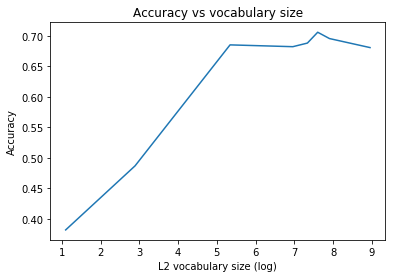

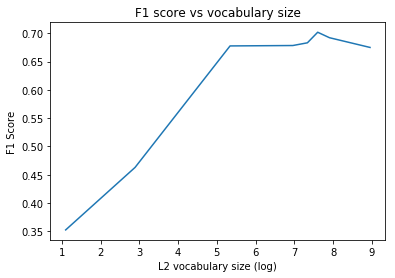

In [382]:
def P6():

### STUDENT START ###

    # Define a few functions to perform major repeating tasks
    
    def get_non_zero_weights(coefs_array):
        '''Returns the total number of non zero coefficients given a fitted model coefficient array'''
        non_zero_coef_num = []  
        non_zero_coef_list = []
        for coef_list in coefs_array:
            non_zero_coef_list.append(get_non_zero_index(coef_list))  
        ## flatten the list of lists
        non_zero_coef_list = [item for sublist in non_zero_coef_list for item in sublist]

        return non_zero_coef_list
    
    def get_non_zero_index(coefs):
        '''Returns the indeces of non zero elements in a list '''
        non_zero_weight_indeces = [] # define an empty list
        non_zero_weight_indeces.append(coefs.nonzero()[0])
        return non_zero_weight_indeces[0]
    
    def get_pruned_vocab(vect,coefs):
            '''Returns a pruned vocabulary'''
            # extract all features with at least one non-zero coefficient
            non_zero_coefs = get_non_zero_weights(coefs)
            non_zero_coefs_unique = np.unique(non_zero_coefs)
            pruned_vocab = [vect.get_feature_names()[k] for k in non_zero_coefs_unique]
            return pruned_vocab

    # Set seed to get consistent results
    np.random.seed(20)
    
    # Logistic regression options
    reg_list=['l1','l2']  # list of all regularization penalties
    C_val=0.1             # reasonable value of regularization paramemter 
    sol = 'liblinear'     # set a solver 
    multi = 'auto'        # set a multi class option
    tolerance=0.01        # set a tolerance for convergence
    
    nonzero_coef_num = {} # empty dictionary
    
    ## Train LR models for L1 and L2 regularization and compute the total number of non zero coefficients
    for index, reg_penalty in enumerate(reg_list):
        vectorizer = CountVectorizer()
        train_features = vectorizer.fit_transform(train_data)
        dev_features = vectorizer.transform(dev_data)
        LR = LogisticRegression(solver=sol, multi_class = multi, penalty=reg_penalty, C=C_val,tol=tolerance)
        LR.fit(train_features, train_labels)
        weights= LR.coef_ 
        ## Get the non zero coefficients from the fitted model
        nonzero_coef_num[reg_penalty] = len(get_non_zero_weights(weights))
        
    ## Print the non zero feature numbers for L1 & L2 regularization penalties and compare with total features in data set
    print_template = '|| {0:30} ||{1:22}|{2:22}|' 
    print(print_template.format('Max non-zero features possible', 'Non Zero features(L1)', 'Non Zero features(L2)'))
    print(print_template.format(train_features.shape[1]*len(categories), nonzero_coef_num['l1'],nonzero_coef_num['l2']))
    print("\n")                                     
    
    ## Search over values of C 
    '''
    Iterate over a list of values of C.
    Prune volcabulary based on l1 regularization and feed the new vocabulary to logistic regression fitting using l2 regularization
    '''
    
    C_list = [1e-3,0.01,0.1,1,2,5,10,100]  # list of C values to fit models over 
    vocab_size = []
    accuracy = []
    f1Score = []
    
    # Setup options and heading for table print within the loop 
    print_format =  '|| {0:10} ||{1:30}|' 
    print(print_format.format("C Value" , "Pruned Vocabulary Size"))
       
    for index,C_val in enumerate(C_list):
        nonzero_index_list = []
        vectorizer = CountVectorizer()
        train_features = vectorizer.fit_transform(train_data)
        reg_penalty = 'l1'  # use L1 regularization to prune vocabulary since L2 will not compute zero coefficients
        LR_L1= LogisticRegression(solver=sol,multi_class=multi, penalty=reg_penalty, C=C_list[index],tol=tolerance)
        LR_L1.fit(train_features, train_labels)
        weights = LR_L1.coef_
        # Get the non zero coefficients
        pruned_vocab = get_pruned_vocab(vectorizer,weights)
       
        print(print_format.format(C_val,len(pruned_vocab)))
        
        # train an L2 reg model with this new vocabulary
        reg_penalty = 'l2'
        vectorizer = CountVectorizer(vocabulary=pruned_vocab)
        train_features = vectorizer.fit_transform(train_data)
        dev_features = vectorizer.transform(dev_data)
        LR_L2= LogisticRegression(solver=sol,multi_class=multi, penalty=reg_penalty, C=C_list[index],tol=tolerance)
        LR_L2.fit(train_features,train_labels)
        LR_L2_predictions = LR_L2.predict(dev_features)
        f1ScoreL2  = metrics.f1_score(dev_labels,LR_L2_predictions,average='weighted')   
        accuracyL2 = float(np.sum(LR_L2_predictions == dev_labels))/len(dev_labels)
        
        ## store the vocab size, f1score and accuracy
        vocab_size.append(len(pruned_vocab))
        f1Score.append(f1ScoreL2)
        accuracy.append(accuracyL2)
        
        
    # Plot accuracy vs vocabulary size
    plt.plot(np.log(vocab_size), accuracy)
    plt.ylabel('Accuracy') 
    plt.xlabel('L2 vocabulary size (log)')
    plt.title('Accuracy vs vocabulary size')  
    plt.show() 
    
         
    # Plot f1 score  vs vocabulary size
    plt.plot(np.log(vocab_size), f1Score)
    plt.ylabel('F1 Score') 
    plt.xlabel('L2 vocabulary size (log)')
    plt.title('F1 score vs vocabulary size')  
    plt.show() 
                              
    ### STUDENT END ###
    
P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [376]:
def P7():

### STUDENT START ###
    def compute_R_ratio(probabilities,correct_lab):
        ''' Ratio R = maximum predicted probability / predicted probability of correct label'''
        max_prob = np.max(probabilities)
        correct_label_prob = probabilities[correct_lab]
        R = max_prob/correct_label_prob
        return R
    
    # compute R ratio statistics for each label
    def R_stats(labels,R):
        '''Mean and variance'''
        R_list = []
        for label in range(len(np.unique(labels))): # loop through each category
            for label_num in range(len(labels)):  # by each label
                if(labels[label_num] == label and R[label_num]!=1):
                    R_list.append(R[label_num])     ## note the R ratio when a mistake is made
            ## report mean and std. deviation of the R ratios when misclassification occured.
            print('Category: {cat}, R (mean): {m}, R (std): {std}'.format(cat=categories[label],
                                  m=np.round(np.mean(R_list),4),std=np.round(np.std(R_list),4)))
    
    # Train the model with TF-IDF transformation of data #
    vectorizer = TfidfVectorizer()
    train_features = vectorizer.fit_transform(train_data)
    dev_features = vectorizer.transform(dev_data)
    LR = LogisticRegression(solver='liblinear',tol=0.01,multi_class='auto',C=100)
    LR.fit(train_features,train_labels)
    LR_prediction_probs = LR.predict_proba(dev_features)
    predictions = LR.predict(dev_features)
    
    ## Calculate R ration for all documents 
    R = map(compute_R_ratio,LR_prediction_probs,dev_labels) 
    R_list = [x for x in R]
    R_list = np.array(R_list)
    index = R_list.argsort()[-3:]  # get the largest 3 R ratios
    #index = np.argpartition(R, -3)[-3:]
    categories.sort()
    for k,idx in enumerate(index):
        print('-'*50)
        print('Mistake: %d\n' %(k+1))
        print('R-ratio: {r}\n'.format(r=round(R_list[idx],2)))
        print('True News Group: {tr}\n'.format(tr=categories[dev_labels[idx]]))
        print('Pre News Group: {cat}\n'.format(cat=categories[predictions[idx]]))
        print('Document text: \n{text}\n'.format(text=dev_data[idx]))
        print('-'*50)
   

    ## Print categories names
    ## Check the R ratio characteristics 
    print('-'*80)
    print('R-ratios given R > 1\n')
    print('-'*80)
    print('R statistics grouped by true dev labels')
    print('-'*80)
    R_stats(dev_labels,R_list)
    print('-'*80, '\n')
    print('-'*80)
    print('R statistics grouped by predicted labels')
    print('-'*80)
    R_stats(predictions,R_list)
        
    print('\nNormalized Confusion matrix\n')
    cm = confusion_matrix(dev_labels,predictions)
    print(np.round(cm/cm.sum(axis=1),3))
                
                
## STUDENT END ###

P7()

--------------------------------------------------
Mistake: 1

R-ratio: 326.57

True News Group: talk.religion.misc

Pre News Group: comp.graphics

Document text: 
Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible.

--------------------------------------------------
--------------------------------------------------
Mistake: 2

R-ratio: 384.55

True News Group: alt.atheism

Pre News Group: talk.religion.misc

Document text: 

The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...


--------------------------------------------------
--------------------------------------------------
Mistake: 3

R-ratio: 926.91

True News Group: talk.religion.misc

Pre News Group: comp.graphics

Document text: 
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn 

ANSWER:

1. TF-IDF is the abbreviation for term frequency–inverse document frequency. It is intended to give the importance of a work for a document and serves as a weighting factor in text feature creation. The TF-IDF increases propotionally as the number of times a word appears in a text and gets offset by the number of document in the data set that contain that word. Thus, it adjusts for the fact that some words appear more frequently than others in general.  

2. Two of the three largest R-ratios are associated with those topics that acutally belong to religion category but predicted to be in conputer graphics category. This could be due to the fact that these text included technical words like ASCII, Latex, RTF, internet, online etc. 

3. In general, we can see from the confusion matrix, that the most confused categories are **alt.atheism** and **talk.religion.misc**(44.8%). This can be expected from the nature of the text present in the two categories.
The misclassification between **comp.graphics** and **talk.religion.misc** is relatively small even though the two highest R ratios are found for these two misclassified categories.

4. Looking at the statistics for the R ratio, we see that when we group by true labels in the dev dataset, the categories atheism and religion have the higher R ratio mean and standard deviation. However, when we group the R ratio statistics by the predicted labels, computer graphics category has the maximum R ratio mean and std. deviation. This suggests that when the true label is computer graphics, our model makes the right prediction most of the time. However, the model predicts computer graphics on most occasions when the true label is something else. 

5. This problem may be fixed by removing some of the non selective features from the model. e.g. if features that predict computer graphics are also common to other categories then we can remove them from the model and this may reduce the misclassification of the labels. 

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

In [370]:
def compute_coef_difference(coefs):
    '''Compute difference as 
        1. Difference of coefficients when largest two are positive
        2. Largest coefficienct when largest is +ve and second largest is -ve
        3. Zero is both are negative
    '''
    
    ## Sort the coefficients in increasing order and find the difference of the largest two
    coefs.sort()
    if coefs[-1] > 0 and coefs[-2] > 0:
        diff = coefs[-1]-coefs[-2]
    elif coefs[-1] > 0:
        diff = coefs[-1]
    else:
        diff = 0 
    return diff


sol = 'liblinear'
multi='auto'
tolerance = 0.01
Cval=0.1

vectorizer = TfidfVectorizer()
train_features = vectorizer.fit_transform(train_data)
max_vocab = train_features.shape[1]
dev_features = vectorizer.transform(dev_data)
LR = LogisticRegression(solver=sol,multi_class=multi,tol=tolerance,C=Cval)
LR.fit(train_features,train_labels)
LR_pred_probs = LR.predict_proba(dev_features)
predictions = LR.predict(dev_features)
f1Score = metrics.f1_score(dev_labels,predictions,average='weighted')
diffs = np.zeros(LR.coef_.T.shape[0])

for index in range(LR.coef_.T.shape[0]):
    diffs[index] = compute_coef_difference(LR.coef_.T[index,:])

## Define a metric for choosing which features to keep as greater than mean of the differences each features largest two values 
diff_mean = np.mean(diffs)
keep_features_indeces = np.where(diffs>=diff_mean)[0]

## Compose a vocabulary for these importatnt features 
new_vocab = [vectorizer.get_feature_names()[index] for index in keep_features_indeces]
#print(new_vocab.shape)
## Train the model with new vocabulary
vectorizer = TfidfVectorizer(vocabulary=new_vocab)
train_features = vectorizer.fit_transform(train_data)
dev_features = vectorizer.transform(dev_data)
LR = LogisticRegression(solver=sol,multi_class=multi,tol=tolerance,C=Cval)
LR.fit(train_features,train_labels)
LR_pred_probs = LR.predict_proba(dev_features)
predictions = LR.predict(dev_features)
f1Score_improved= metrics.f1_score(dev_labels,predictions,average='weighted')

# ------------ print(results --------------------- #
print("Original:\n")
print("Vocabulary size: {feat}".format(feat=max_vocab))
print("F1-score: {f1s}\n".format(f1s=f1Score))
print("Improved:\n")
print("Vocabulary size: {feat}".format(feat=train_features.shape[1]))
print("F1-score: {f1s}".format(f1s=f1Score_improved))


Original:

Vocabulary size: 26879
F1-score: 0.5426633423690569

Improved:

Vocabulary size: 6970
F1-score: 0.5664067348589755


Answer: 

We see above that there is a 2 point increase in F1 score with a substantial reduction in vocabulary size is obtained by implementing the improvements in feature extraction.